#Get data from VPS

In [61]:
#Data handling
import numpy as np
import pandas as pd
import simplejson as json

#Server
import urllib2

#Timestamp handling
from datetime import datetime

#GUI
import Tkinter as tk

#Plotting
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import dates as mdates
from matplotlib.ticker import LinearLocator

##Selection of server data

In [65]:
class server_GUI(tk.Frame):
    def __init__(self, parent, *args, **kwargs):
        tk.Frame.__init__(self, parent, *args, **kwargs)
        self.grid()
        self.parent = parent
        
        self.link = ""
        self.devices = ['53ff6d066667574831402467','54ff69066667515129441567']
        
        self.date_format = '%Y-%m-%d %H:%M:%S'
        self.initial_value = ['Hour','Day','07','2015']
        self.all_options = [['%02d'%(i) for i in range(1,24)],['%02d'%(i) for i in range(1,32)],['%02d'%(i) for i in range(1,13)],range(2015,2016)]
        
        
    def select_date(self):
        
        #DEVICE
        self.device = tk.StringVar(self.parent)
        self.device.set('53ff6d066667574831402467')
        tk.Label(self.parent, text="Select device:").grid(row=0,column=0)
        apply(tk.OptionMenu, (self.parent, self.device) + tuple(self.devices)).grid(row=0,column=1)
        
        #START DATE
        tk.Label(self.parent, text="Select start date:").grid(row=1)
        self.var_start = [tk.StringVar(self.parent) for i in range(len(self.initial_value))]
        for i in range(len(self.initial_value)):
            self.var_start[i].set(self.initial_value[i])
            apply(tk.OptionMenu, (self.parent, self.var_start[i]) + tuple(self.all_options[i])).grid(row=2,column=i)
        
        #END DATE
        tk.Label(self.parent, text="Select end date:").grid(row=3)
        self.var_end = [tk.StringVar(self.parent) for i in range(len(self.initial_value))]
        for i in range(len(self.initial_value)):
            self.var_end[i].set(self.initial_value[i])
            apply(tk.OptionMenu, (self.parent, self.var_end[i]) + tuple(self.all_options[i])).grid(row=4,column=i)
        
        tk.Button(self.parent, text='OK', command=self.ok).grid(row=5,column=5)
        
    def ok(self):
        try:
            start = datetime(int(self.var_start[3].get()),int(self.var_start[2].get()),int(self.var_start[1].get()),int(self.var_start[0].get()))
            end =  datetime(int(self.var_end[3].get()),int(self.var_end[2].get()),int(self.var_end[1].get()),int(self.var_end[0].get()))
            print "The start date is {},\n the end date {},\n the device number is {}.\n".format(start.strftime(self.date_format),end.strftime(self.date_format),self.device.get())
            
            self.link = "http://109.237.25.161/particle/events?start_date={}&end_date={}&device={}".format(start.strftime(self.date_format),end.strftime(self.date_format),self.device.get())
            print "Created link {}\n".format(self.link)
            
            self.parent.quit()
        
        except:
            print "Please try again!"

root = tk.Tk()
root.title('Select data to be fetched')

App = server_GUI(root)
App.select_date()

root.mainloop()
root.destroy()

The start date is 2015-07-21 10:00:00,
 the end date 2015-07-23 23:00:00,
 the device number is 53ff6d066667574831402467.

Created link http://109.237.25.161/particle/events?start_date=2015-07-21 10:00:00&end_date=2015-07-23 23:00:00&device=53ff6d066667574831402467



In [66]:
decoded_json = json.loads(urllib2.urlopen(App.link).read())['events']

date_format = '%Y-%m-%d %H:%M:%S'
dat = []
timestamp = []

for line in decoded_json:
    buf = [x.strip() for x in line['data'].split(",")]
    
    if len(buf)==5:
            dat.append(buf)
            timestamp.append(datetime.strptime(line['timestamp'],date_format))
    elif len(buf)==2:
            try:
                dat[-1].append(buf[0])
                dat[-1].append(buf[1])
            except IndexError:
                continue
    else:
            continue

print "Data has been fetched.\n"


Data has been fetched.



In [67]:
params = ["temp","light","noise_max","noise_av","noise_var","pir_per","pir_num"]

df = pd.DataFrame(new, index=timestamp, columns=params)
df = df.convert_objects(convert_numeric=True)

print "Data has been added to a pandas dataframe:\n"
print df.describe()

ValueError: Shape of passed values is (7, 2993), indices imply (7, 149)

##Plot fetched data:

Plots of raw data:



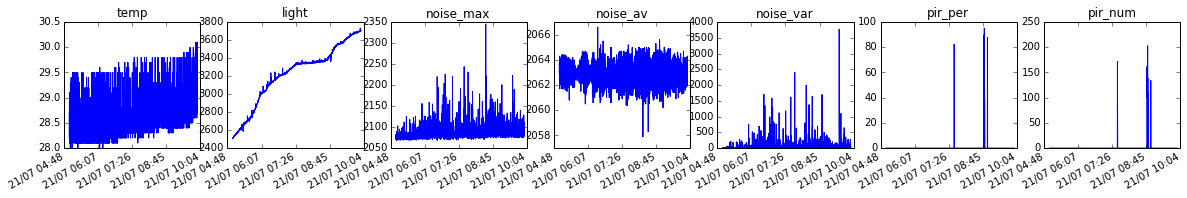

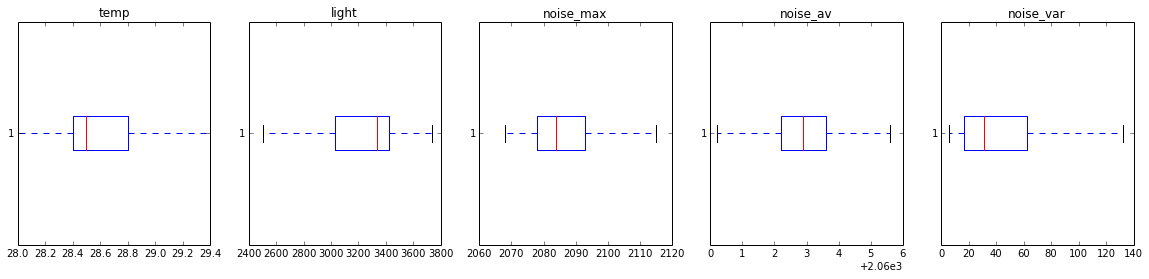

In [57]:
#PLOT
hfmt = mdates.DateFormatter('%d/%m %H:%M')

fig, axs = plt.subplots(1,len(params), sharex=True, figsize=(20,2.5))

print "Plots of raw data:\n"

for i in range(len(params)):
    para = params[i]
    axs[i].plot(df[para].index,df[para].values)
    axs[i].set_title(para)
    axs[i].xaxis.set_major_formatter(hfmt)
    axs[i].xaxis.set_major_locator(LinearLocator(numticks=5))

fig.autofmt_xdate()

fig, axs = plt.subplots(1,len(params)-2, sharex=False, figsize=(20,4))

for i in range(len(params)-2):
    para = params[i]
    axs[i].boxplot(df[para].values,0,'',0)
    axs[i].set_title(para)

##Filtering:

The signals are being Gauss filterd:



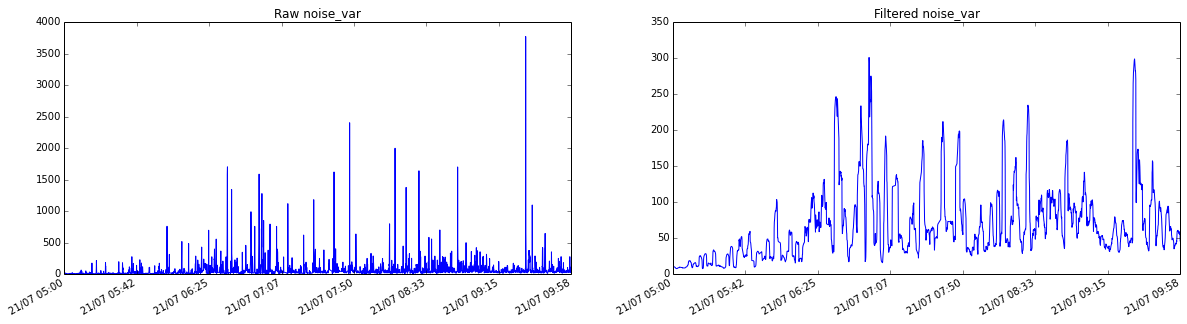

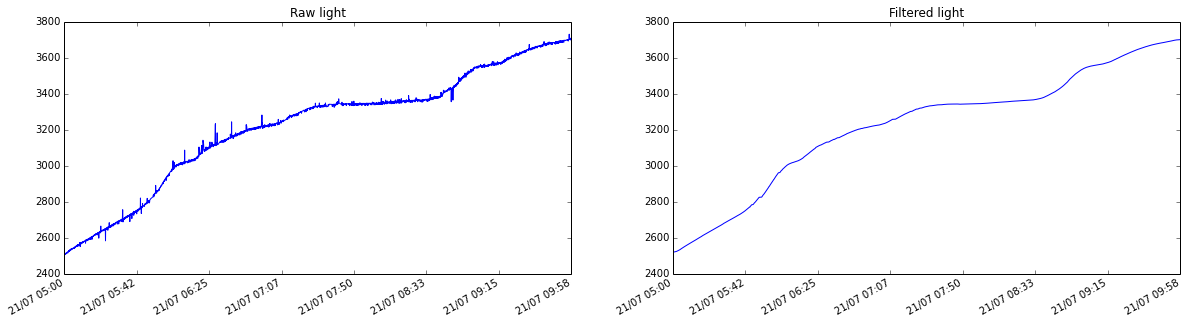

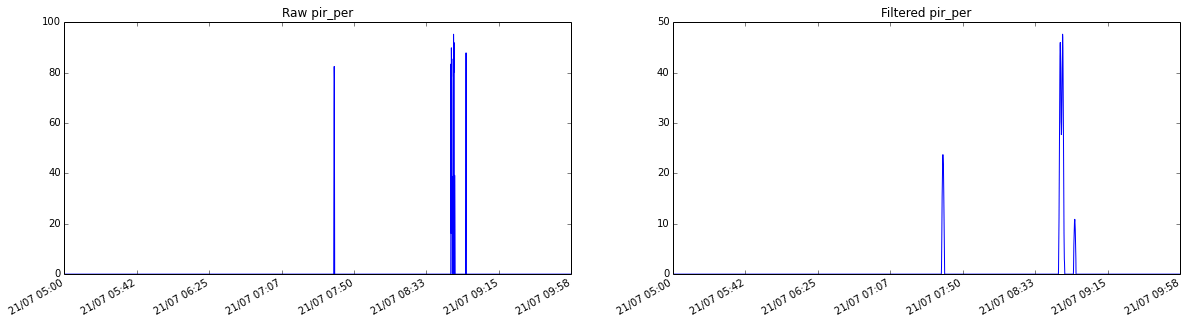

In [58]:
from scipy.signal import gaussian
from scipy.ndimage import filters

def Gauss_filt(y, M, std):
    b = gaussian(M, std)
    ga = filters.convolve1d(y, b/b.sum())
    return ga

para = ["noise_var","light","pir_per"]
filt_params = np.array([[20,15],[100,60],[15,5]], dtype=int)
filt_sig = np.zeros((df.count()[0],len(para)))

print "The signals are being Gauss filterd:\n"

for i in range(len(para)):
    
    filt_sig[:,i] = Gauss_filt(df[para[i]].values,filt_params[i,0],filt_params[i,1])

    fig, axs = plt.subplots(1, 2, sharex=True, figsize=(20,5))
    hfmt = mdates.DateFormatter('%d/%m %H:%M')

    axs[0].plot(df[para[i]].index,df[para[i]].values)
    axs[1].plot(df[para[i]].index,filt_sig[:,i])

    axs[0].set_title("Raw {}".format(para[i]))
    axs[1].set_title("Filtered {}".format(para[i]))

    for i in range(2):
        axs[i].xaxis.set_major_formatter(hfmt)
        axs[i].xaxis.set_major_locator(LinearLocator(numticks=8))

    fig.autofmt_xdate()


##Normalise signals

For this selection, the min is 7.61644598747 and the max is 300.909663302 (noise_var)
For this selection, the min is 2522.66372409 and the max is 3702.55742529 (light)
For this selection, the min is 0.0 and the max is 47.6054616082 (pir_per)


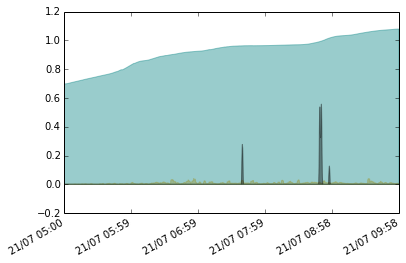

In [59]:
norm_sig = np.zeros(filt_sig.shape,dtype=float)
cols = ['orange','teal','black']
#mins and max from whole database as of 20 July (for normalisation):
min_max = np.array([[2.30302599633,7422.44563997],[362.349324163,3460.20613676],[0.0,85.4879737739]]) 

fig, ax = plt.subplots()

#para = ["noise_var","light","pir_per"]
for i in range(len(para)):
    #norm_sig[:,i] = (filt_sig[:,i]-np.nanmin(filt_sig[:,i]))/(np.nanmax(filt_sig[:,i])-np.nanmin(filt_sig[:,i]))
    norm_sig[:,i] = (filt_sig[:,i]-min_max[i,0])/(min_max[i,1]-min_max[i,0])
    print "For this selection, the min is {1} and the max is {2} ({0})".format(para[i], np.nanmin(filt_sig[:,i]), np.nanmax(filt_sig[:,i]))
    ax.fill_between(df.index,0,norm_sig[:,i],color=cols[i],alpha=.4)

hfmt = mdates.DateFormatter('%d/%m %H:%M')

fig.autofmt_xdate()
ax.xaxis.set_major_locator(LinearLocator(numticks=6))
ax.xaxis.set_major_formatter(hfmt)

##Infere some stuff:

(0, 1)

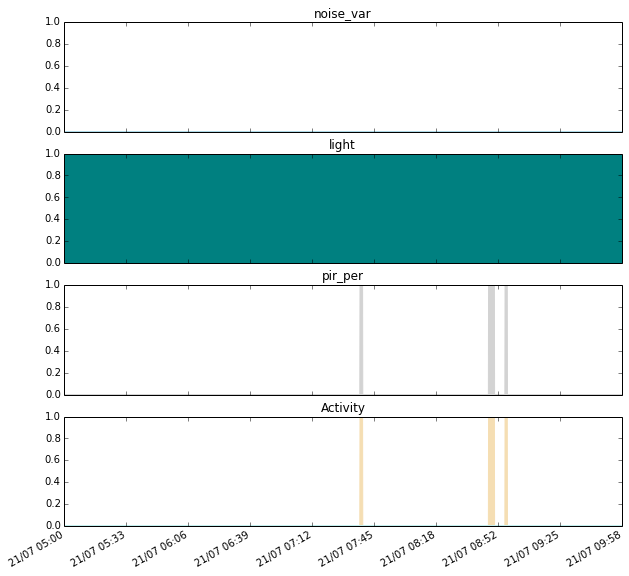

In [60]:
treshold = np.array([.1,.05,.05])
lines = np.zeros(filt_sig.shape, dtype=int)

#para = ["noise_var","light","pir_per"]
for i in range(len(para)):
    lines[:,i] = [1 if x>treshold[i] else 0 for x in norm_sig[:,i]]

day_active_high = [1 if (x==1 and y==1 and z==1) else 0 for (x,y,z) in lines]
day_active_low = [1 if (x==0 and y==1 and z==1) else 0 for (x,y,z) in lines]
night_active_high = [1 if (x==1 and y==0 and z==1) else 0 for (x,y,z) in lines]
night_active_low = [1 if (x==0 and y==0 and z==1) else 0 for (x,y,z) in lines]

fig, axs = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(10,10))
cols = ['lightblue','teal','lightgray']

for i in range(3):
    axs[i].fill_between(df.index,0,lines[:,i],color=cols[i])
    axs[i].set_title("{}".format(para[i]))
    
axs[3].fill_between(df.index,0,day_active_high,color="orange")
axs[3].fill_between(df.index,0,day_active_low,color="wheat")
axs[3].fill_between(df.index,0,night_active_high,color="darkcyan")
axs[3].fill_between(df.index,0,night_active_low,color="lightcyan")

axs[3].set_title("Activity")

hfmt = mdates.DateFormatter('%d/%m %H:%M')

fig.autofmt_xdate()
axs[0].xaxis.set_major_locator(LinearLocator(numticks=10))
axs[0].xaxis.set_major_formatter(hfmt)
axs[0].set_ylim(0,1)

##Binning the data first 5min bins instead of filtering

In [23]:
from datetime import timedelta
import time 

#test = pd.DataFrame(norm_sig, index=timestamp, columns=para)

delta = 300

df['epoch'] = [(ts-datetime(1970,1,1)).total_seconds() for ts in df.index]
bins = np.arange(min(df.epoch),max(df.epoch)+delta,delta)

#grouped = test.groupby(pd.cut(test.epoch, bins))

def bin_from_tstamp(tstamp):
    diffs = [abs(tstamp - b) for b in bins]
    return bins[diffs.index(min(diffs))]

grouped = df.groupby(df['epoch'].map(
    lambda t: datetime.fromtimestamp(bin_from_tstamp(t))
))

binned_mean = grouped.mean()
print binned_mean.head()

                          temp        light    noise_max     noise_av  \
epoch                                                                   
2015-07-03 07:00:04  29.485714  1541.380952  2086.904762  2068.957143   
2015-07-03 07:05:04  29.490625  1541.156250  2084.875000  2068.843750   
2015-07-03 07:10:04  29.468519  1536.296296  2089.018519  2068.922222   
2015-07-03 07:15:04  29.536364  1537.254545  2091.981818  2068.876364   
2015-07-03 07:20:04  29.558333  1536.350000  2089.300000  2068.948333   

                     noise_var  pir_per  pir_num         epoch  
epoch                                                           
2015-07-03 07:00:04   7.004762        0        0  1.435903e+09  
2015-07-03 07:05:04   5.915625        0        0  1.435904e+09  
2015-07-03 07:10:04   7.300000        0        0  1.435904e+09  
2015-07-03 07:15:04  15.067273        0        0  1.435904e+09  
2015-07-03 07:20:04  15.445000        0        0  1.435904e+09  


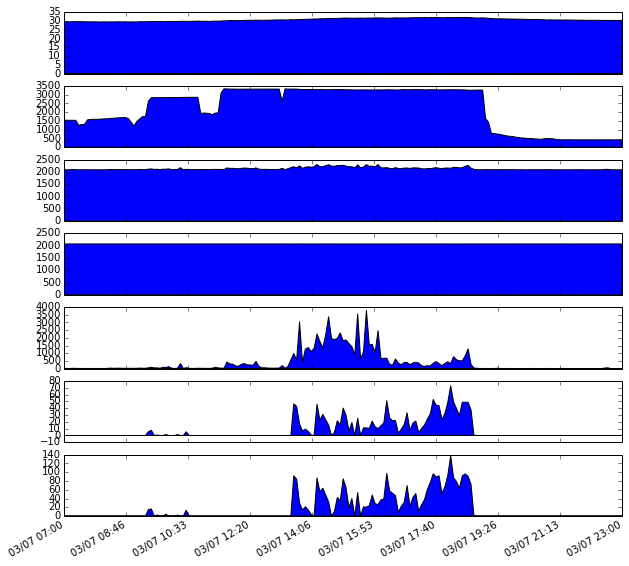

In [24]:
fig, axs = plt.subplots(7, 1, sharex=True, sharey=False, figsize=(10,10))
cols = ['lightblue','teal','lightgray']

params = ["temp","light","noise_max","noise_av","noise_var","pir_per","pir_num"]

for i in range(len(params)):
    axs[i].fill_between(binned_mean.index,0,binned_mean[params[i]].values)

hfmt = mdates.DateFormatter('%d/%m %H:%M')

fig.autofmt_xdate()
axs[0].xaxis.set_major_locator(LinearLocator(numticks=10))
axs[0].xaxis.set_major_formatter(hfmt)
#axs[0].set_ylim(0,1)
#axs[0].set_xlim('2015-07-03 09:05:05','2015-07-03 10:55:05')

In [25]:
print binned_mean.describe()

#para = ["noise_var","light","pir_per"]
min_max = np.array([[2.831667,5125.926667],[355.454545,3821.083333],[0.0,72.854902]]) 

             temp        light    noise_max     noise_av    noise_var  \
count  193.000000   193.000000   193.000000   193.000000   193.000000   
mean    30.607656  2247.678783  2128.068051  2068.779053   376.107607   
std      0.840360  1163.451839    54.013367     0.263658   702.007975   
min     29.354717   421.285714  2083.016667  2067.666667     3.816667   
25%     29.770000  1293.875000  2088.509091  2068.768085     6.315385   
50%     30.495000  2837.586957  2098.432432  2068.844444    28.795455   
75%     31.502778  3278.156863  2156.885714  2068.926087   361.475000   
max     31.931429  3330.156250  2300.181818  2069.231429  3782.847917   

          pir_per     pir_num         epoch  
count  193.000000  193.000000  1.930000e+02  
mean     7.744121   16.115113  1.435932e+09  
std     14.582026   29.142379  1.675460e+04  
min      0.000000    0.000000  1.435903e+09  
25%      0.000000    0.000000  1.435918e+09  
50%      0.000000    0.000000  1.435932e+09  
75%      9.373585   

##Normalise these signals

For this selection, the min is 3.81666666667 and the max is 3782.84791667 (noise_var)
For this selection, the min is 421.285714286 and the max is 3330.15625 (light)
For this selection, the min is 0.0 and the max is 72.8549019608 (pir_per)


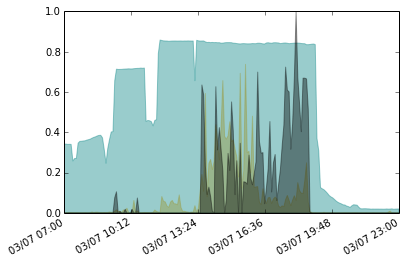

In [26]:
norm_sig = np.zeros((binned_mean.count()[0],len(para)),dtype=float)
cols = ['orange','teal','black']

fig, ax = plt.subplots()

#para = ["noise_var","light","pir_per"]
for i in range(len(para)):
    norm_sig[:,i] = (binned_mean[para[i]].values-min_max[i,0])/(min_max[i,1]-min_max[i,0])
    print "For this selection, the min is {1} and the max is {2} ({0})".format(para[i], np.nanmin(binned_mean[para[i]].values), np.nanmax(binned_mean[para[i]].values))
    ax.fill_between(binned_mean.index,0,norm_sig[:,i],color=cols[i],alpha=.4)

hfmt = mdates.DateFormatter('%d/%m %H:%M')

fig.autofmt_xdate()
ax.xaxis.set_major_locator(LinearLocator(numticks=6))
ax.xaxis.set_major_formatter(hfmt)

(0, 1)

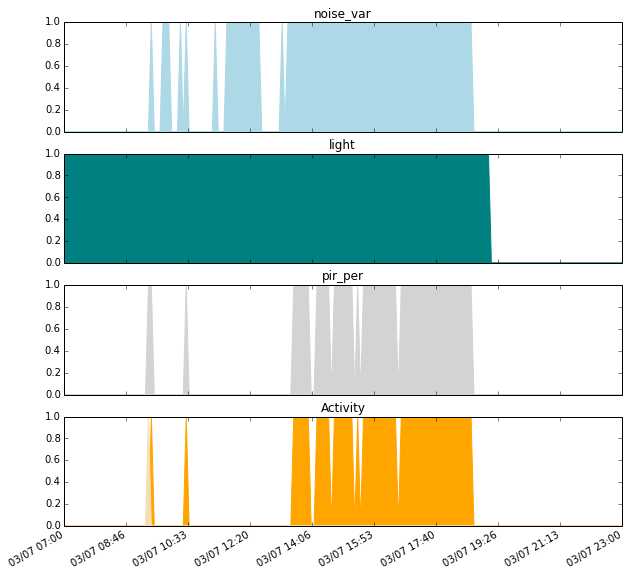

In [27]:
treshold = np.array([.01,.2,.05])
lines = np.zeros(norm_sig.shape, dtype=int)

#para = ["noise_var","light","pir_per"]
for i in range(len(para)):
    lines[:,i] = [1 if x>treshold[i] else 0 for x in norm_sig[:,i]]

day_active_high = [1 if (x==1 and y==1 and z==1) else 0 for (x,y,z) in lines]
day_active_low = [1 if (x==0 and y==1 and z==1) else 0 for (x,y,z) in lines]
night_active_high = [1 if (x==1 and y==0 and z==1) else 0 for (x,y,z) in lines]
night_active_low = [1 if (x==0 and y==0 and z==1) else 0 for (x,y,z) in lines]

fig, axs = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(10,10))
cols = ['lightblue','teal','lightgray']

for i in range(3):
    axs[i].fill_between(binned_mean.index,0,lines[:,i],color=cols[i])
    axs[i].set_title("{}".format(para[i]))
    
axs[3].fill_between(binned_mean.index,0,day_active_high,color="orange")
axs[3].fill_between(binned_mean.index,0,day_active_low,color="wheat")
axs[3].fill_between(binned_mean.index,0,night_active_high,color="darkcyan")
axs[3].fill_between(binned_mean.index,0,night_active_low,color="lightcyan")

axs[3].set_title("Activity")

hfmt = mdates.DateFormatter('%d/%m %H:%M')

fig.autofmt_xdate()
axs[0].xaxis.set_major_locator(LinearLocator(numticks=10))
axs[0].xaxis.set_major_formatter(hfmt)
axs[0].set_ylim(0,1)